# Titanic Survival Prediction 
Kaggle getting started challenge

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

Data exploration and cleaning

In [124]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Looking for duplicates, no repeating passenger ids.

In [125]:
data['PassengerId'].value_counts()

1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: PassengerId, Length: 891, dtype: int64

Verifying integrity of response variable, we can tell that the classes are unbalanced

In [126]:
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

We have three features that have missing values, they are: Age, Cabin and Embarked. 

The cabin feature has more values missing than actual values, so its not possible to use only the passengers that have this value, since this would drastically decrease our available data to train the model. Its also hard to even imput this data, since most of it is unknow the results would not be reliable. Considering the nature of this variable as well as some intuition, we can say that possibly this feature would have some impact on the probability of survival, (depending on the location of the ship it might be easier to access the emergency boats), but proably not the most important. So, in order to have reliable features to train the model, we will ignore the cabin number.

The Embarked feature really only have two missing numbers, and there are three possible values. It is safe to say that imputing these values will not significantly change our analisys, so we will use the mode of the rest of the data to imput the missing values.

Age on the other hand could be a very important factor when predicting the survival of a passengers, older people and children are more vulnerable. But, on the other hand, there are not a lot of values missing, so it is possible to try to use model based prediction of these features to imput data, or just ignoring the passengers that dont have this feature complete. Going forward I will test both strategies and compare the ones that give the best results at the end. 

First i will ignore the passagers with missing age values, and try to find the best strategy with the remaining data. Once i decide on the best model. I will then try to predict the value of the missing features and retrain the chosen model including the predicted values. If it increases the test accuracy we will use it. 

Removing "Cabin" column

In [127]:
data_clean = data.drop(columns='Cabin')

Locating the null age values and dropping them

In [128]:
missing_age_mask = data['Age'].isnull()
data_clean = data_clean.loc[~missing_age_mask,:].copy()
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  714 non-null    int64  
 1   Survived     714 non-null    int64  
 2   Pclass       714 non-null    int64  
 3   Name         714 non-null    object 
 4   Sex          714 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        714 non-null    int64  
 7   Parch        714 non-null    int64  
 8   Ticket       714 non-null    object 
 9   Fare         714 non-null    float64
 10  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.9+ KB


Locating the null "Embarked" values and imputing them with the mode

In [129]:
missing_embarked_mask = data['Embarked'].isnull()
data_clean['Embarked'][missing_embarked_mask] = data_clean.mode(axis = 0)['Embarked'][0]
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  714 non-null    int64  
 1   Survived     714 non-null    int64  
 2   Pclass       714 non-null    int64  
 3   Name         714 non-null    object 
 4   Sex          714 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        714 non-null    int64  
 7   Parch        714 non-null    int64  
 8   Ticket       714 non-null    object 
 9   Fare         714 non-null    float64
 10  Embarked     714 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.9+ KB
ipykernel_launcher:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


From the cleaned dataset, we will not use all columns as features, as some of those have absolutely no preditive value, in our case: ID, Name, and Ticket. All of those are random values that serve to identify the passager in different ways, but give no information relevant to survival rates. 

In [130]:
data_clean.reset_index(inplace = True)
data_clean

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...,...
709,885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,Q
710,886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
711,887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
712,889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


We will now verify if the values of the features we have left on our clean dataframe are coherent with what we would expect

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

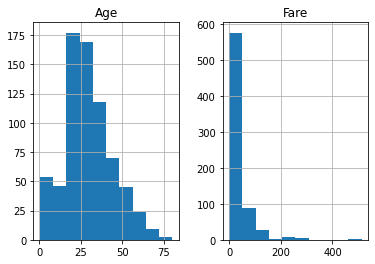

In [131]:
data_clean[['Age', 'Fare']].hist(layout=(1,2))

Age and fare seem to all have valid numbers, and a reasonable distribution, no reason to doubt what we have here

In [132]:
data_clean['Pclass'].value_counts()

3    355
1    186
2    173
Name: Pclass, dtype: int64

In [133]:
data_clean['Sex'].value_counts()

male      453
female    261
Name: Sex, dtype: int64

In [134]:
data_clean['SibSp'].value_counts()

0    471
1    183
2     25
4     18
3     12
5      5
Name: SibSp, dtype: int64

In [135]:
data_clean['Parch'].value_counts()

0    521
1    110
2     68
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

In [136]:
data_clean['Embarked'].value_counts()

S    556
C    130
Q     28
Name: Embarked, dtype: int64

Pclass seems ok, most people are on third class, and a minority on first class, as expected.

Sex at first glance might look weird, as normally we would expect a rate of men to women around 50/50, but we need to remind ourselves that most of the ships crew is most likely male, which could unbalance this class.

SibSp and Parch seem resonable, most people have 0 (we can again think about the crew), a considerable amount has one or two, and very few have from 3 to 6 spouse and siblings or parents and children. 

Embarked has only valid values, and its not surprising that different harbors will have more or less passengers embarking.

The last step is implementing a One hot encoding to turn the categorical features "Sex" and Embarked into something numeric that can be used by our models.

In [137]:
enc = OneHotEncoder(handle_unknown='ignore')

sex_ohe = enc.fit_transform(data_clean[['Sex']]).toarray()
sex_ohe_df = pd.DataFrame(sex_ohe, columns = ['Female', 'Male'])

embarked_ohe = enc.fit_transform(data_clean[['Embarked']]).toarray()
embarked_ohe_df = pd.DataFrame(embarked_ohe, columns = ['Cherbourg', 'Queenstown', 'Southampton'])

data_clean = pd.concat([data_clean, sex_ohe_df, embarked_ohe_df], axis = 1)

data_clean

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Female,Male,Cherbourg,Queenstown,Southampton
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0.0,1.0,0.0,0.0,1.0
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1.0,0.0,1.0,0.0,0.0
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1.0,0.0,0.0,0.0,1.0
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1.0,0.0,0.0,0.0,1.0
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,Q,1.0,0.0,0.0,1.0,0.0
710,886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,0.0,1.0,0.0,0.0,1.0
711,887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,1.0,0.0,0.0,0.0,1.0
712,889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,0.0,1.0,1.0,0.0,0.0


In [138]:
data_clean.to_csv('train_cleaned.csv')
df = data_clean.copy()

We now conclude our basic exploration of the data, and will begin to experiment with models.

In [153]:
features = df.columns.tolist()
remove = ['PassengerId', 'Survived', 'Name', 'Ticket', 'Sex', 'Embarked', 'index']
features = [element for element in features if element not in remove]
response = ['Survived']

In [188]:
#X_train, X_test, y_train, y_test = train_test_split(df[features], df[response], test_size=0.2)
X = df[features]
y = df[response]

In [189]:
X.shape

(714, 10)

Random Forest

we have in total 571 samples, that means that with a tree of depth 9 we have close to individual leafs for each sample (theoretical limit) but that would mean the tree is extremely overfit. We will explore tree depths up to 8. 

In [192]:
hyper_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9], 'n_estimators': [25, 50, 100, 150, 200, 250, 300]}

In [193]:
random_forest = RandomForestClassifier(criterion='gini',min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight='balanced')

In [199]:
cross_validation = GridSearchCV(random_forest, hyper_params, scoring='roc_auc', n_jobs=None, refit=True, cv=4, verbose=1, pre_dispatch=None, error_score=np.nan, return_train_score=True)

In [200]:
cross_validation.fit(X_train, y_train.values.ravel())

Fitting 4 folds for each of 49 candidates, totalling 196 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [25, 50, 100, 150, 200, 250, 300]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [196]:
cv_results_df = pd.DataFrame(cross_validation.cv_results_)

In [197]:
feat_imp_df = pd.DataFrame({'Feature name':features,'Importance':cross_validation.best_estimator_.feature_importances_})
feat_imp_df.sort_values('Importance', ascending=False)

,Feature name,Importance
5,Female,0.200700
6,Male,0.196316
4,Fare,0.190353
1,Age,0.168627
0,Pclass,0.122961
2,SibSp,0.056877
3,Parch,0.032365
7,Cherbourg,0.016327
9,Southampton,0.010687
8,Queenstown,0.004786


Here we can see which features were the most important when classifying our samples. Not surprisingly the sex was the most important one, followed closely by fare age and Pclass. 

Fare and Pclass are direct measures of economic status, and its very likely that richer passengers would have some priority to access to survival boats for example. Age has a huge impact in physical endurance, and it obviously is an important factor in suvivability, also it could play a role in decision making of the group, to protect the children. And finally sex, given the gender roles of the men as the "protectors" and women as "fragile" it could be that a lot of men sacrificed themselves to save women, (like we saw diCaprio do on the movie). 

From everything we can see, the results seem to be very logical.

[Text(0, 0.5, '3'),
 Text(0, 1.5, '4'),
 Text(0, 2.5, '5'),
 Text(0, 3.5, '6'),
 Text(0, 4.5, '7'),
 Text(0, 5.5, '8'),
 Text(0, 6.5, '9')]

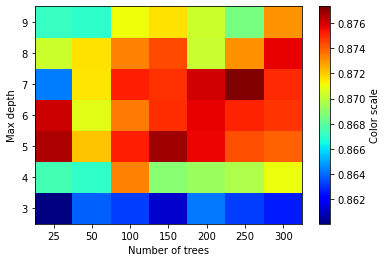

In [198]:
xx, yy = np.meshgrid(range(8), range(8))
z_test_score = cv_results_df['mean_test_score'].values.reshape(7,7)

ax = plt.axes()
colormesh = ax.pcolormesh(xx, yy, z_test_score, cmap = plt.cm.jet)
plt.colorbar(colormesh, label='ROC-AUC Score')
ax.set_xlabel('Number of trees')
ax.set_ylabel('Max depth')
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_xticklabels([str(tick_label) for tick_label in hyper_params['n_estimators']])
ax.set_yticklabels([str(tick_label) for tick_label in hyper_params['max_depth']])

We can observe that due to variability of the samples chosen in each fold, and the relatively low number of samples, the chart shows some variability on results. Still we can see a clear tendency of higher scores between 150 and 250 trees and 5 and 7 max depth. So we will chose a max depth of 6, and 200 trees as the hyperparameters of our model.